In [37]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import nltk
import re
import pickle

pd.set_option('display.max_colwidth', None)

In [38]:
df = pd.read_csv("/kaggle/input/casedatasi/sample_data.csv")

In [39]:
df.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


<Axes: xlabel='label', ylabel='Count'>

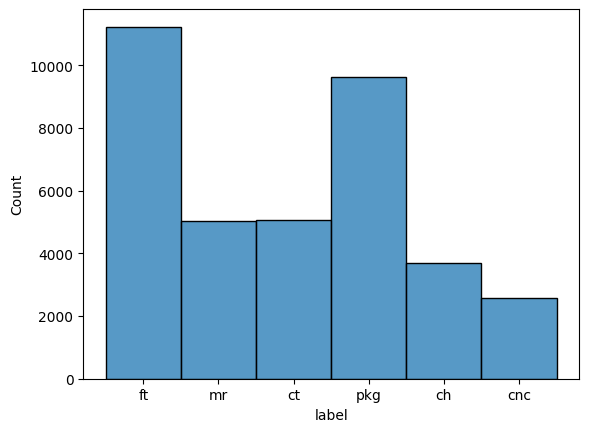

In [40]:
sns.histplot(data=df, x="label")

In [41]:
df['text'] = df['text'].str.lower()

In [42]:
df.isna().sum()

text       0
label    100
dtype: int64

# EDA CLEANING

In [43]:
# Some rows has this symbol, label distribution are same it doesn't contain any information, so will be dropped
df[df.text == "吉祥"].label.value_counts()

label
mr     50
ct     50
pkg    50
cnc    50
ch     50
ft     50
Name: count, dtype: int64

In [44]:
# Also same rows are consist of just empty space, it doesn't contain any information, so will be dropped
df[df.text == " "].label.value_counts()

label
mr     50
cnc    50
ft     50
pkg    50
ct     50
ch     50
Name: count, dtype: int64

In [45]:
# There is some rows only contain just numbers, label distribution are same it doesn't contain any information, so will be dropped
df[df['text'].str.match(r'^\d+$')].label.value_counts()

label
cnc    50
ct     50
ch     50
ft     50
pkg    50
mr     50
Name: count, dtype: int64

# When we look closely, these numbers are not random, it repeating itself for every label. If this number some sort of a serial number for future predictions we can know which label this numbers are going to be.But for this projects sake I will drop them but further investigation can be done with the business team.

In [46]:
# this text start from 40254401 and adding 6 to each subsequent number
pkg_num = df[(df['text'].str.match(r'^\d+$')) & (df.label == "pkg")]
pkg_num.loc[:, 'text'] = pkg_num['text'].astype(int)
pkg_num.sort_values('text').head(10)

,text,label
27773,40254401,pkg
11536,40254407,pkg
37079,402544013,pkg
35495,402544019,pkg
549,402544025,pkg
700,402544031,pkg
29143,402544037,pkg
36596,402544043,pkg
28516,402544049,pkg
35093,402544055,pkg


In [47]:
# this ft start from 40254402 and adding 6 to each subsequent number
ft_num = df[(df['text'].str.match(r'^\d+$')) & (df.label == "ft")]
ft_num.loc[:, 'text'] = ft_num['text'].astype(int)
ft_num.sort_values('text').head(10)

,text,label
14970,40254402,ft
14482,40254408,ft
37084,402544014,ft
19649,402544020,ft
32282,402544026,ft
34003,402544032,ft
11257,402544038,ft
3271,402544044,ft
8654,402544050,ft
12134,402544056,ft


In [48]:
# Some text contains emails, it doesn't contain any information, so will be dropped
df[df['text'].str.contains(r'[@]')].label.value_counts()

label
mr     50
cnc    50
ch     50
pkg    50
ft     50
ct     50
Name: count, dtype: int64

In [50]:
# Also dropping empty rows
df = df[(df.text.isna() == False) &(df.text != " ") & (df.text != "吉祥") 
        & (~df['text'].str.match(r'^\d+$')) & (~df['text'].str.contains(r'[@]'))]

# Checking for duplicates, some rows appers more than in the dataset.Also for same text values there are two labels.I will correct them accordingly.

In [51]:
df[df.duplicated(subset = 'text', keep = False)][["text","label"]].sort_values('text').value_counts().tail(40)

text                                               label
flowpack verpackung                                pkg      2
geothermische bohrungen                            ct       1
abstandhalter kunststoff                           mr       1
biologische verpackungen                           pkg      1
geothermische bohrungen                            mr       1
spirituosen abfüller                               ft       1
                                                   pkg      1
cnc laserschneiden                                 mr       1
messer für haushaltswaren                          ft       1
                                                   mr       1
biologische verpackungen                           ft       1
cnc drehereien                                     mr       1
abstandhalter kunststoff                           pkg      1
cnc drehereien                                     cnc      1
cnc cutter                                         ft       1
             

In [52]:
df.loc[df.text == "spirituosen abfüller", "label"] = "pkg"
df.loc[df.text == "geothermische bohrungen", "label"] = "mr"
df.loc[df.text == "cnc cutter", "label"] = "cnc"
df.loc[df.text == "hersteller werkzeugmaschinen", "label"] = "cnc"
df.loc[df.text == "gebrauchte holzbearbeitungsmaschinen", "label"] = "cnc"
df.loc[df.text == "messer für haushaltswaren", "label"] = "mr"
df.loc[df.text == "kunststoff zerspanung", "label"] = "mr"
df.loc[df.text == "carbonplatten fräsen", "label"] = "cnc"
df.loc[df.text == "lohnabfüllung olivenöl" , "label"] = "ft"
df.loc[df.text == "lohnabfüllung nahrungsergänzung", "label"] = "ft"
df.loc[df.text == "lohnabfüllung konfitüre", "label"] = "ft"
df.loc[df.text == "kunststoffdosen lebensmittel", "label"] = "pkg"
df.loc[df.text == "kunststoff zerspanung", "label"] = "mr"
df.loc[df.text == "kunststoff tempern" , "label"] = "pkg"
df.loc[df.text == "cnc laserschneiden", "label"] = "cnc"
df.loc[df.text == "auftauanlagen für gefrorene lebensmittel", "label"] = "ft"
df.loc[df.text == "cnc abkantpresse" ,"label"] = "cnc"
df.loc[df.text == "cnc drehereien", "label"] = "cnc"
df.loc[df.text == "abstandhalter kunststoff" , "label"] = "mr"
df.loc[df.text == "lohnabfüllung von ampullen für chemische lösungen", "label"] = "ch"
df.loc[df.text == "vorschubwalzen für holzbearbeitungsmaschinen", "label"] = "cnc"
df.loc[df.text == "biologische verpackungen", "label"] = "pkg"
df.loc[df.text == "werkzeugmaschinen hersteller","label"] = "cnc"

In [53]:
df.drop_duplicates(subset = ['text'], keep = 'first', inplace=True)

In [54]:
df[df.duplicated(subset = 'text', keep = False)]

,text,label


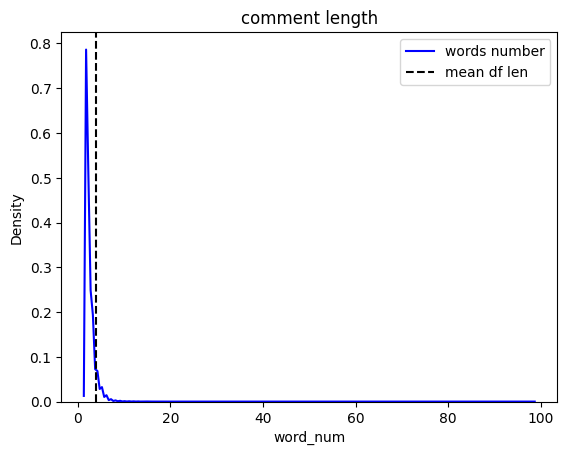

In [55]:
df['word_num'] = df['text'].str.split(" ").str.len()
mean_len_df = np.round(df['word_num'].mean() + df['word_num'].std()).astype(int)
sns.kdeplot(df['word_num'], color='b', label='words number')
plt.axvline(x=mean_len_df, color='k', linestyle='--', label='mean df len')
plt.title('comment length'); plt.legend()
plt.show()

In [56]:
# There is some rows contains long sentences,so using bert or lstm based models require long padding.
df.word_num.value_counts().sort_index()

word_num
2     21236
3      7206
4      2288
5       984
6       399
7       138
8        63
9        39
10       19
11       15
12       10
13        7
14        3
15        4
16        1
17        3
18        2
19        1
25        1
31        1
32        1
34        1
46        1
47        1
48        1
68        2
70        2
71        1
74        1
76        1
83        1
85        1
93        1
98        1
Name: count, dtype: int64

In [57]:
df.isna().sum()

text          0
label       100
word_num      0
dtype: int64

In [58]:
# Dropping empty label rows
df.dropna(inplace=True)

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(df.text, df.label,
                                                  stratify = df.label.values,
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [66]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

param_grid = {
    'vectorizer__min_df': [1,2,3],
    'vectorizer__max_features': [2000,3000,5000],
    'vectorizer__strip_accents': ['unicode'],
    'vectorizer__analyzer': ['word'],
    'vectorizer__token_pattern': [r'\w{1,}'],
    'vectorizer__ngram_range': [(1, 2),(1, 3)],
    'classifier__alpha': [0.3, 0.5, 0.8, 1]
}

skf = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(pipeline, param_grid,
    scoring=make_scorer(f1_score, average='macro'), cv=skf)

grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
print('#' * 20)
f1 = f1_score(y_train, y_train_pred, average='macro')
print("F1 score on train set:", f1)
print('Classification Report for BERT:\n', classification_report(y_train, y_train_pred))

print('#' * 20)

print('#'*20)
print("Best Parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)
print('#'*20)

y_val_pred = grid_search.predict(X_valid)
f1 = f1_score(y_valid, y_val_pred, average='macro')
print("F1 score on validation set:", f1)
print('Classification Report for BERT :\n', classification_report(y_valid, y_val_pred))

####################
F1 score on train set: 0.8979890863981099
Classification Report for BERT:
               precision    recall  f1-score   support

          ch       0.96      0.87      0.91      2828
         cnc       0.90      0.79      0.84      1881
          ct       0.95      0.92      0.93      3983
          ft       0.89      0.95      0.92      8794
          mr       0.90      0.85      0.88      3889
         pkg       0.89      0.93      0.91      7727

    accuracy                           0.91     29102
   macro avg       0.92      0.88      0.90     29102
weighted avg       0.91      0.91      0.91     29102

####################
####################
Best Parameters: {'classifier__alpha': 1, 'vectorizer__analyzer': 'word', 'vectorizer__max_features': 5000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__strip_accents': 'unicode', 'vectorizer__token_pattern': '\\w{1,}'}
Best F1 score: 0.8626796242954914
####################
F1 score on vali

In [70]:
with open ('murat_grid-0.1.pkl', 'wb') as f:
    pickle.dump(grid_search, f)